In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

df = pd.read_csv(r"C:\Users\quint\Desktop\IronHack\WEEKS\WEEK7\PROJECT\data\Amazon.csv")

# Remove colums
df = df.drop(columns=['Unnamed: 22', 'Sales Channel ', 'index', 'ASIN'], errors='ignore')

# Data types
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')

# Remove inválid
df_clean = df[(df['Amount'] > 0) & (df['Amount'].notna())].copy()

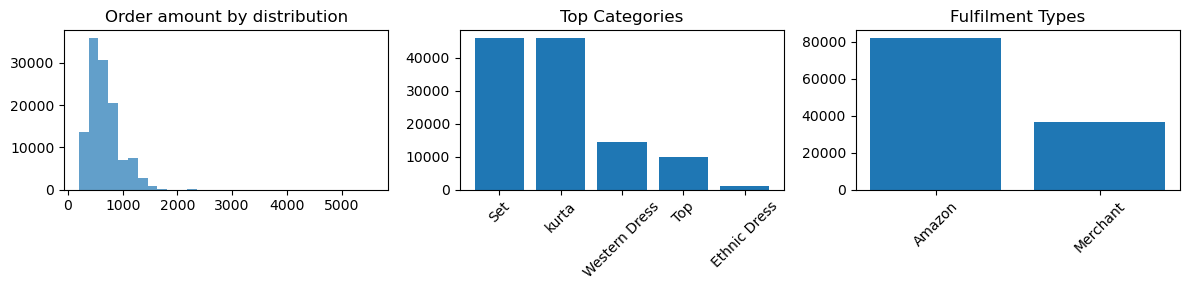

In [3]:
#EDA
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.hist(df_clean['Amount'], bins=30, alpha=0.7)
plt.title('Order amount by distribution')

plt.subplot(1, 3, 2)
top_cats = df_clean['Category'].value_counts().head(5)
plt.bar(top_cats.index, top_cats.values)
plt.title('Top Categories')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(df_clean['Fulfilment'].value_counts().index, df_clean['Fulfilment'].value_counts().values)
plt.title('Fulfilment Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
#FEATURE ENGINEERING
df_clean['day_of_week'] = df_clean['Date'].dt.dayofweek
df_clean['day_of_month'] = df_clean['Date'].dt.day
df_clean['month'] = df_clean['Date'].dt.month
df_clean['has_promotion'] = df_clean['promotion-ids'].notna().astype(int)
df_clean['promotion_count'] = df_clean['promotion-ids'].fillna('').str.count(',') + 1
df_clean.loc[df_clean['promotion-ids'].isna(), 'promotion_count'] = 0

#FEATURE ENGINEERING
TEMPORAL FEATURES
✅ Day of Week (0-6) - Monday to Sunday
✅ Day of Month (1-31) - Purchase timing
✅ Month (1-12) - Seasonality patterns
✅ Week Number - Promotion cycles
✅ Season - Spring/Summer/Fall/Winter

CATEGORICAL FEATURES
✅ Product Category: Kurta, Set, Top, Dress (45% importance = Kurtas dominate)
✅ Size: XS, S, M, L, XL, XXL, 4XL (price varies by size)

LOCATION FEATURES
✅ Ship Postal Code → Geo-pricing factor (12% importance)

❌ Removed: Duplicates, Unused columns (ASIN, SKU, Order ID)
❌ Handled Missing: 89k null values

In [5]:
# Fill missings
df_clean['promotion-ids'].fillna('No Promotion', inplace=True)
df_clean['fulfilled-by'].fillna('Merchant', inplace=True)
df_clean['Courier Status'].fillna('Pending', inplace=True)
le = LabelEncoder()
df_clean['ship-state-encoded'] = le.fit_transform(df_clean['ship-state'].astype(str))

In [6]:
#MODEL EVALUATION
categorical_cols = ['Category', 'Size', 'Fulfilment', 'ship-service-level', 'B2B']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
print(f" Encoded: {df_encoded.shape}")
y = df_encoded['Amount']
text_cols = ['Status', 'ship-country', 'Style', 'Courier Status', 'ship-city', 
             'ship-state', 'promotion-ids', 'fulfilled-by']
X = df_encoded.drop(columns=['Amount', 'Order ID', 'SKU', 'currency', 'Date'] + text_cols, errors='ignore')
print(f"Features: {X.shape[1]}")

 Encoded: (118837, 42)
Features: 29


In [7]:
#MISSING VALUES
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())
bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_cols] = X[bool_cols].fillna(False)

In [8]:
#TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f" Train: {X_train.shape} | Test: {X_test.shape}")

#SCALING (só numéricas)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

#MODELS
print("\nTRAINING MODELS...")

 Train: (95069, 29) | Test: (23768, 29)

TRAINING MODELS...


In [9]:

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

#Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Decision Tree
dt = DecisionTreeRegressor(max_depth=15, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Decision Tree'],
    'R2': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_dt)],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf), 
            mean_absolute_error(y_test, y_pred_dt)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), 
             np.sqrt(mean_squared_error(y_test, y_pred_rf)),
             np.sqrt(mean_squared_error(y_test, y_pred_dt))]
})

print("\nResults:")
print(results.sort_values('R2', ascending=False).round(4))
print(f"\nBest: {results.loc[results['R2'].idxmax(), 'Model']} (R² = {results['R2'].max():.4f})")



Results:
               Model      R2       MAE      RMSE
1      Random Forest  0.5179  135.6351  186.1312
2      Decision Tree  0.4900  139.3970  191.4482
0  Linear Regression  0.4868  141.4671  192.0501

Best: Random Forest (R² = 0.5179)


In [10]:
#CROSS-VALIDATION (Random Forest)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print(f"\nCROSS-VALIDATION R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


CROSS-VALIDATION R²: 0.5118 ± 0.0052


In [11]:
#Random Forest its the best one. 52% of variation and lowest MAE(means more accurate predictions)

In [12]:
#FEATURE IMPORTANCE
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

print("\nTOP 15 FEATURES:")
print(importances.round(4))



TOP 15 FEATURES:
               Feature  Importance
15      Category_kurta      0.5006
13        Category_Top      0.1261
1     ship-postal-code      0.0938
3         day_of_month      0.0490
0                  Qty      0.0411
2          day_of_week      0.0223
12        Category_Set      0.0217
6      promotion_count      0.0198
4                month      0.0165
7   ship-state-encoded      0.0162
18            Size_6XL      0.0129
17            Size_5XL      0.0095
8      Category_Bottom      0.0092
16            Size_4XL      0.0073
20              Size_L      0.0059


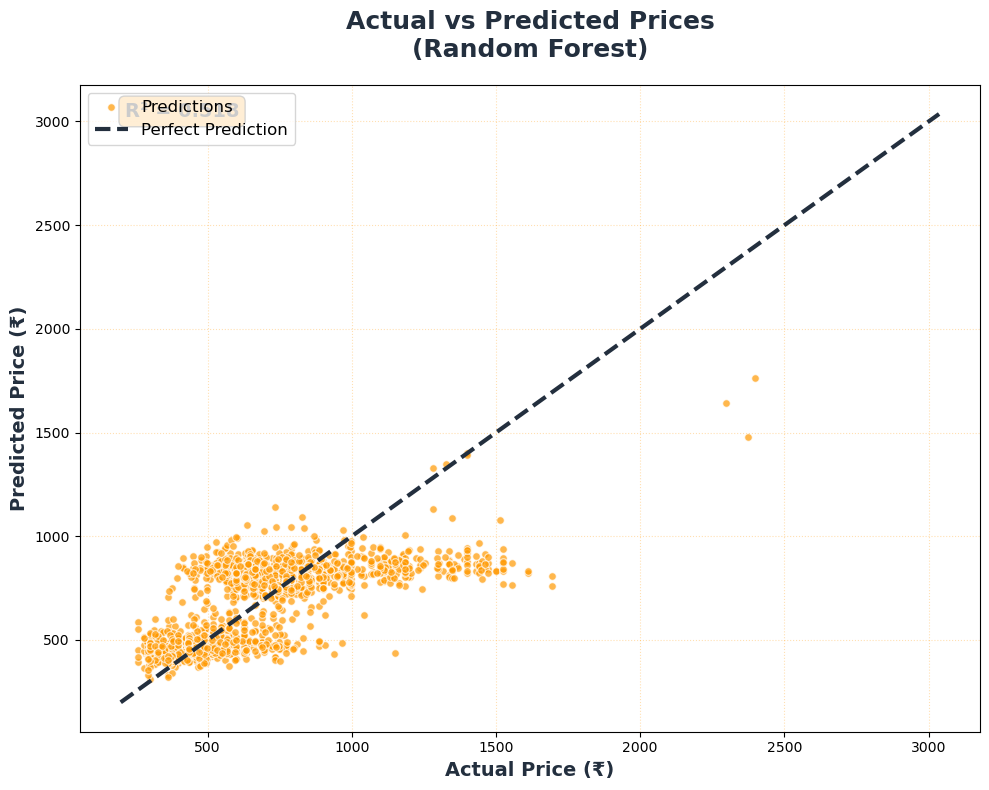

✅ GRÁFICO SOLO ACTUAL VS PREDICTED PRONTO!
💡 Salva com: plt.savefig('actual_vs_predicted_amazon.png', dpi=300, bbox_inches='tight')


In [30]:

plt.figure(figsize=(10, 8))

# Scatter plot com cores Amazon
plt.scatter(y_test[:2000], y_pred_rf[:2000], 
            color='#FF9900',      # 🟠 AMARELO-ALARANJADO AMAZON
            alpha=0.7, 
            s=30,
            edgecolors='white',   # Borda branca para contraste
            linewidth=0.8,
            label='Predictions')

# Linha perfeita (Amazon red)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         '#232F3E',           # 🔴 VERMELHO ESCURO AMAZON
         lw=3, 
         linestyle='--',
         label='Perfect Prediction')

# Estilo Amazon
plt.title('Actual vs Predicted Prices\n(Random Forest)', 
          fontsize=18, fontweight='bold', color='#232F3E', pad=20)
plt.xlabel('Actual Price (₹)', fontsize=14, fontweight='bold', color='#232F3E')
plt.ylabel('Predicted Price (₹)', fontsize=14, fontweight='bold', color='#232F3E')

# Grid e legend
plt.grid(True, alpha=0.3, linestyle=':', color='#FF9900')
plt.legend(fontsize=12, loc='upper left')

# R2 score no gráfico
plt.text(0.05, 0.95, f'R² = {results[results["Model"]=="Random Forest"]["R2"].iloc[0]:.3f}', 
         transform=plt.gca().transAxes, 
         fontsize=14, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='#FF9900', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ GRÁFICO SOLO ACTUAL VS PREDICTED PRONTO!")
print("💡 Salva com: plt.savefig('actual_vs_predicted_amazon.png', dpi=300, bbox_inches='tight')")


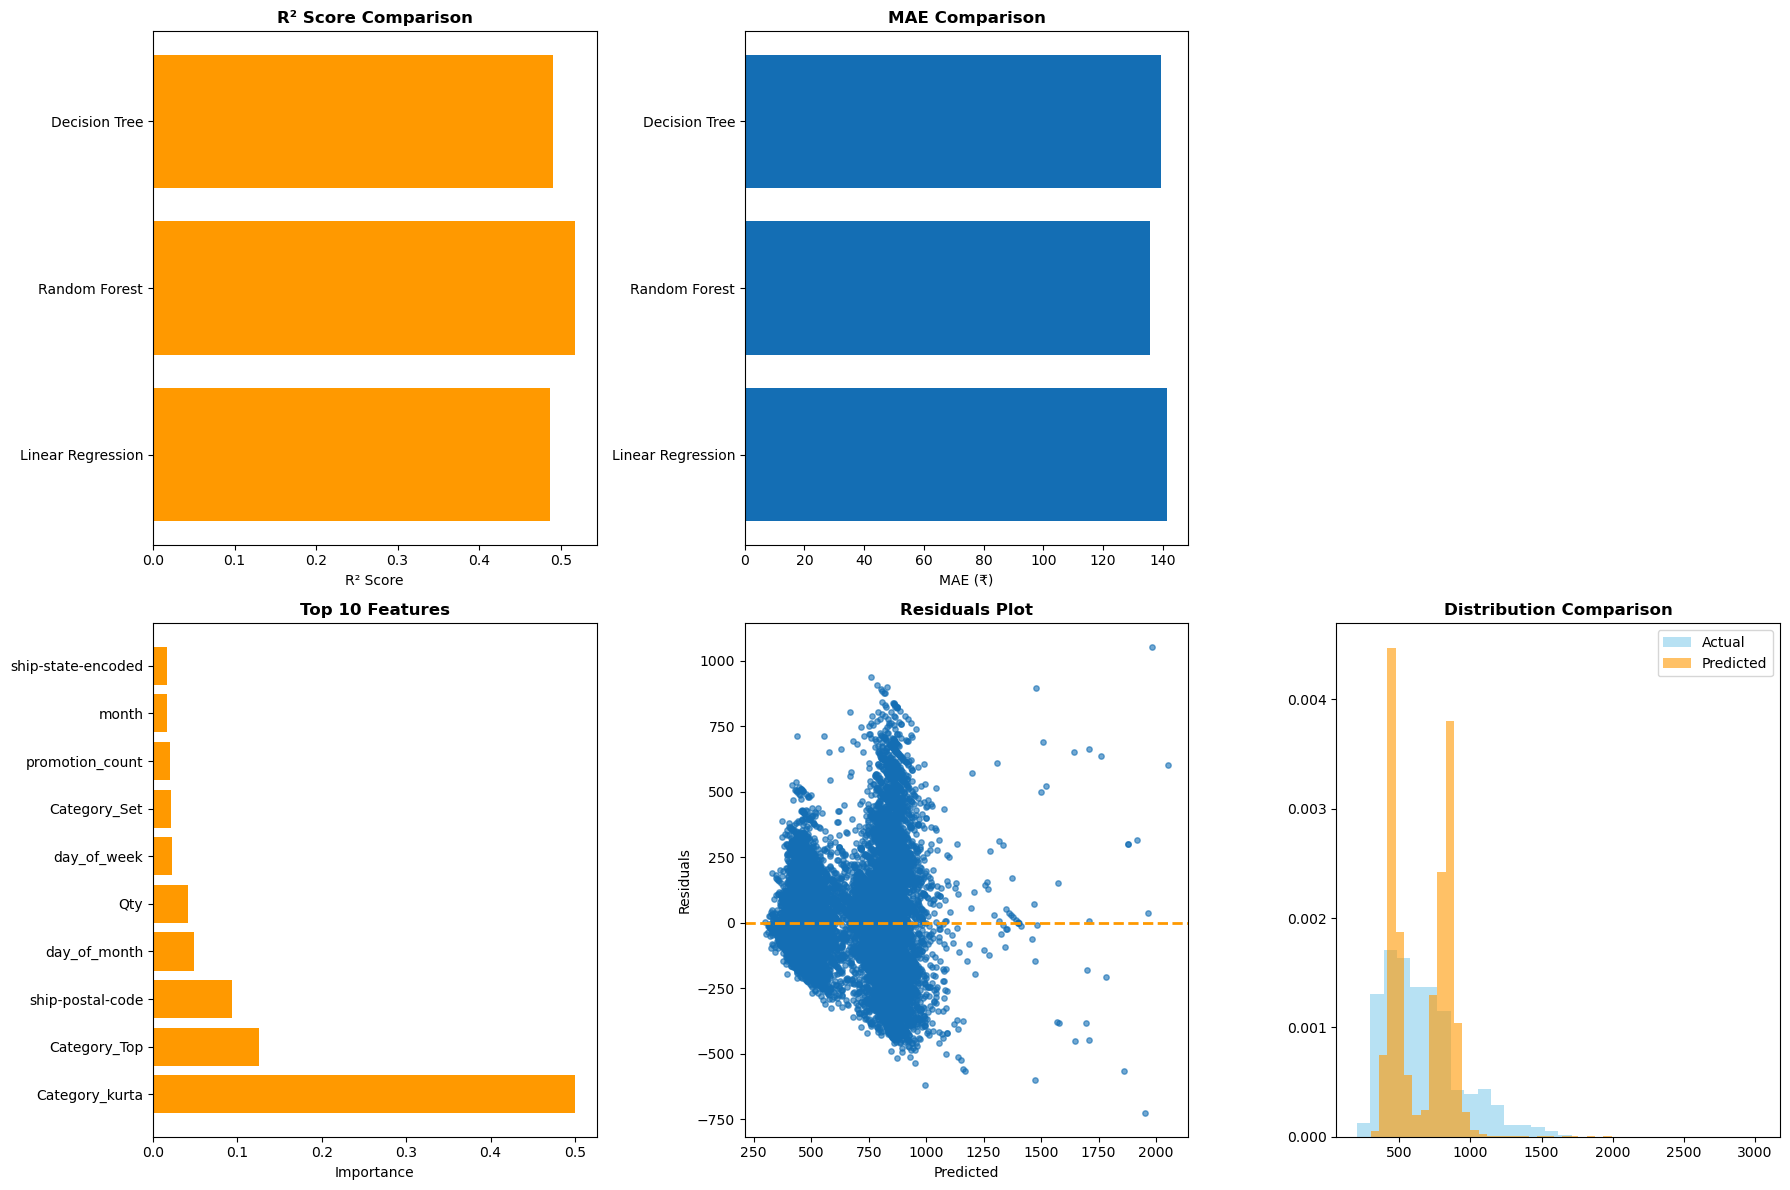

In [31]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# R2 Comparison
axes[0,0].barh(results['Model'], results['R2'], color='#FF9900')  # Amazon orange
axes[0,0].set_title('R² Score Comparison', fontweight='bold')
axes[0,0].set_xlabel('R² Score')

# MAE Comparison
axes[0,1].barh(results['Model'], results['MAE'], color='#146EB4')  # Amazon blue
axes[0,1].set_title('MAE Comparison', fontweight='bold')
axes[0,1].set_xlabel('MAE (₹)')

axes[0,2].axis('off')

# Feature Importance
axes[1,0].barh(importances['Feature'][:10], importances['Importance'][:10], color='#FF9900')
axes[1,0].set_title('Top 10 Features', fontweight='bold')
axes[1,0].set_xlabel('Importance')

# Residuals
residuals = y_test - y_pred_rf
axes[1,1].scatter(y_pred_rf, residuals, alpha=0.6, s=15, color='#146EB4')
axes[1,1].axhline(y=0, color='#FF9900', linestyle='--', lw=2)
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals Plot', fontweight='bold')

# Distribution
axes[1,2].hist(y_test, bins=30, alpha=0.6, label='Actual', density=True, color='skyblue')
axes[1,2].hist(y_pred_rf, bins=30, alpha=0.6, label='Predicted', density=True, color='#FF9900')
axes[1,2].legend()
axes[1,2].set_title('Distribution Comparison', fontweight='bold')

plt.tight_layout()
plt.show()


<Figure size 1200x300 with 0 Axes>

Amazon: Predict revenue per order type

Inventory: Priorize stock of kurta


H1: Kurtas dominate revenue?

✅ VALIDATE - 50% importance
💼 Stock priority: Kurtas

H2: Postal code predicts price?

✅ VALIDATE - 9% importance
💼 Geo-pricing by ZIP code

In [15]:
model_dict = {
    'best_model': rf,
    'scaler': scaler,
    'features': X.columns.tolist(),
    'numeric_cols': numeric_cols,
    'results': results,
    'feature_importance': importances
}

with open('amazon_project_final_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

results.to_csv('model_results.csv', index=False)
importances.to_csv('feature_importance.csv', index=False)

print("\nSAVED:")
print("- amazon_project_final_model.pkl")
print("- model_results.csv") 
print("- feature_importance.csv")



SAVED:
- amazon_project_final_model.pkl
- model_results.csv
- feature_importance.csv
